In [1]:
import os
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import sys
from utils import utils, warp, image_utils, constant_var
from models import end_2_end_optimization
from options import fake_options
from utils.image_utils import *
import cv2

/home/skocznapanda/programming/BSc-soccer-annotator/venv/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
image_array = cv2.imread('/home/skocznapanda/programming/BSc-soccer-annotator/automatic_models/lines_and_field_detection/sportsfield_release/data/frame_100.jpg')


In [3]:
line_detector = LineDetector(image_array=image_array)

In [4]:
field, lines, homography = line_detector()

---------------------- NOTIFICATION ----------------------

Resnet backbone config for loss_surface
Spectral norm for resnet: True
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for loss_surface
From: ./sportsfield_release/out/pretrained_loss_surface/checkpoint.pth.tar

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Resnet backbone config for init_guess
Spectral norm for resnet: False
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: ./sportsfield_release/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------
---------------------- NOTIFICATION ---------

  0%|          | 0/30 [00:00<?, ?it/s]/home/skocznapanda/programming/BSc-soccer-annotator/venv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/skocznapanda/programming/BSc-soccer-annotator/venv/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


In [14]:
type(homography)
print(homography)
homography.detach().numpy()

tensor([[[ 0.3134,  0.0026, -0.0857],
         [-0.0564,  1.2556, -0.0307],
         [ 0.0192,  0.9757,  1.0000]]], grad_fn=<ViewBackward0>)


array([[[ 0.31342277,  0.00260905, -0.08574601],
        [-0.05635619,  1.255592  , -0.03072759],
        [ 0.0192227 ,  0.97571117,  1.        ]]], dtype=float32)

(720, 1280, 3)

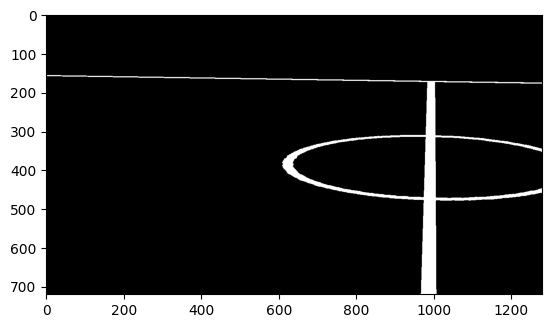

In [27]:
lines = result.copy()
mask = result[:,:,0] < 0.7
lines[mask] = 0
lines[~mask] = 1
plt.imshow(lines)
lines.shape


In [45]:
x = np.any(lines > 0, axis=2).astype(np.int32)
np.all(x == (x > 0).astype(np.int32))

True

In [8]:
result.min(), result.max()

(0.0, 1.0)

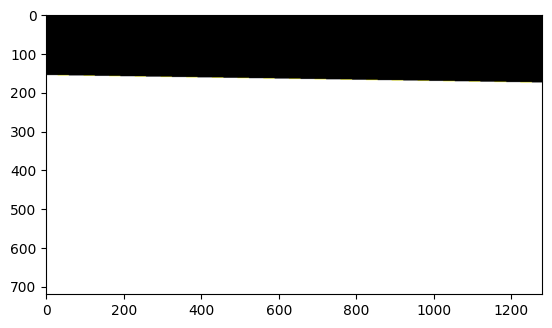

In [9]:
mask = result > 0
only_field = result.copy()
only_field[mask] = 1
plt.imshow(only_field)

In [17]:
reshaped = only_field.reshape((only_field.size,))
import pandas as pd
pd.Series(reshaped).value_counts()

1.0    2125830
0.0     638970
dtype: int64

## ORIGINAL SPORTFIELD PACKAGE

/tmp/ipykernel_7258/217307674.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  goal_image = imageio.imread(opt.goal_image_path, pilmode='RGB')
/tmp/ipykernel_7258/217307674.py:37: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)


tensor(7.3490)
mean of goal image: -1.2417634698280722e-09
std of goal image: 0.9999948740005493


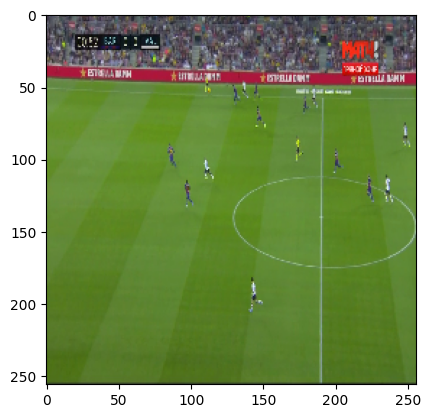

In [13]:

constant_var.USE_CUDA = False
utils.fix_randomness()

# if GPU is RTX 20XX, please disable cudnn
torch.backends.cudnn.enabled = False
# set some options
opt = fake_options.FakeOptions()
opt.batch_size = 1
opt.coord_conv_template = True
opt.error_model = 'loss_surface'
opt.error_target = 'iou_whole'
opt.goal_image_path = '/home/skocznapanda/programming/BSc-soccer-annotator/automatic_models/lines_and_field_detection/sportsfield_release/data/frame_100.jpg'
opt.guess_model = 'init_guess'
opt.homo_param_method = 'deep_homography'
opt.load_weights_error_model = 'pretrained_loss_surface'
opt.load_weights_upstream = 'pretrained_init_guess'
opt.lr_optim = 1e-5
opt.need_single_image_normalization = True
opt.need_spectral_norm_error_model = True
opt.need_spectral_norm_upstream = False
opt.optim_criterion = 'l1loss'
opt.optim_iters = 200
opt.optim_method = 'stn'
opt.optim_type = 'adam'
opt.out_dir = './out'
opt.prevent_neg = 'sigmoid'
opt.template_path = './data/world_cup_template.png'
opt.warp_dim = 8
opt.warp_type = 'homography'
# read original image
goal_image = imageio.imread(opt.goal_image_path, pilmode='RGB')
#plt.imshow(goal_image)
#plt.show()
# resize image to square shape, 256 * 256, and squash to [0, 1]
pil_image = Image.fromarray(np.uint8(goal_image))

pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
goal_image = np.array(pil_image)
#print(goal_image.max())
#plt.imshow(goal_image)
#plt.show()
# covert np image to torch image, and do normalization
plt.imshow(goal_image)
goal_image = utils.np_img_to_torch_img(goal_image)


if opt.need_single_image_normalization:
    goal_image = image_utils.normalize_single_image(goal_image)
    print(goal_image.max())
print('mean of goal image: {0}'.format(goal_image.mean()))
print('std of goal image: {0}'.format(goal_image.std()))

In [17]:
class Person():
    pass

In [12]:
goal_image.std()

tensor(1.0000)

In [13]:
goal_image[1]

tensor([[-2.3849, -2.6631, -2.3153,  ..., -2.0022, -2.1414, -1.8979],
        [-2.1066, -2.1762, -1.3066,  ..., -2.0022, -2.2805, -2.3153],
        [-2.2457, -2.1762, -1.8631,  ...,  0.7456, -2.4544, -2.0718],
        ...,
        [-0.4718, -0.4370, -0.4023,  ..., -0.0196,  0.0499,  0.0847],
        [-0.5762, -0.5066, -0.6109,  ..., -0.0892, -0.0892, -0.0544],
        [-1.7588, -1.7936, -1.8979,  ..., -1.9327, -1.8979, -1.8631]])

In [5]:
array == goal_image

NameError: name 'goal_image' is not defined